<a href="https://colab.research.google.com/github/garv26/Sentiment-analyzer/blob/main/lstm_model_kfold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Installing required libraries**

In [ ]:
!pip install pandas
!pip install scikeras
!pip install --upgrade tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import re
import os
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from bs4 import BeautifulSoup
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, KFold

import keras
import tensorflow as tf
#import tensorflow_datasets as tfds
# import tensorflow_text
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPool1D, GlobalAveragePooling1D, LSTM, Bidirectional
from tensorflow.python.client import device_lib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV


## **Importing Dataset**

In [ ]:
df = pd.read_csv("/content/amazon_reviews.csv")
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0


### **Create Sentiment Feature**

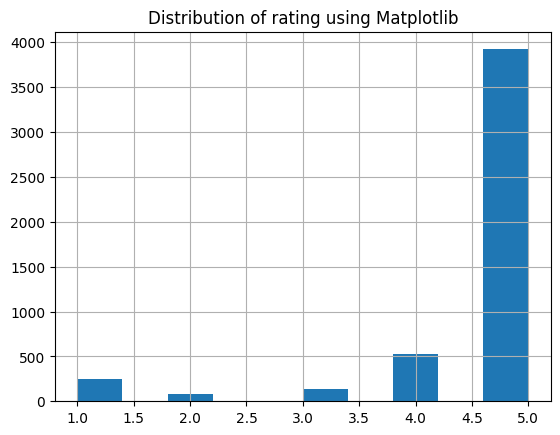

In [ ]:
df.overall.hist()
plt.title("Distribution of rating using Matplotlib")
plt.show()

In [ ]:
df["sentiments"] = df.overall.apply(lambda x: 0 if x in [1,2] else 1)
df = df.astype({"reviewText": str})
df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,helpful_yes,helpful_no,total_vote,score_pos_neg_diff,score_average_rating,wilson_lower_bound,sentiments
0,0,NaN,4.0,No issues.,2014-07-23,138,0,0,0,0,0.0,0.0,1
1,1,0mie,5.0,"Purchased this for my device, it worked as adv...",2013-10-25,409,0,0,0,0,0.0,0.0,1
2,2,1K3,4.0,it works as expected. I should have sprung for...,2012-12-23,715,0,0,0,0,0.0,0.0,1
3,3,1m2,5.0,This think has worked out great.Had a diff. br...,2013-11-21,382,0,0,0,0,0.0,0.0,1
4,4,2&amp;1/2Men,5.0,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513,0,0,0,0,0.0,0.0,1


### ***Variables Declaration ***

In [ ]:
vocab_size = 5000
oov_token = "<OOV>"
test_size = 0.20

max_length = 100
padding_type = "post"
num_folds = 5

### **Data Preprocessing**

In [ ]:
df = df[['reviewText', 'sentiments']]
df.head()

,reviewText,sentiments
0,No issues.,1
1,"Purchased this for my device, it worked as adv...",1
2,it works as expected. I should have sprung for...,1
3,This think has worked out great.Had a diff. br...,1
4,"Bought it with Retail Packaging, arrived legit...",1


In [ ]:
df.shape

(4915, 2)

In [ ]:
df.isnull().sum()

reviewText    0
sentiments    0
dtype: int64

In [ ]:
df['sentiments'].value_counts()

1    4591
0     324
Name: sentiments, dtype: int64

In [ ]:
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# 1. lowering case
df['reviewText'] = df['reviewText'].str.lower()  # lowering the case!
# 2. remove punctuation!
df['reviewText'] = df['reviewText'].apply(lambda x: re.sub('[^a-z A-Z]+', '', x))  # it removes the punctuation
# 3. remove stopwords! (you can check the notebook, if you have any doubt)
from spacy.lang.en.stop_words import STOP_WORDS
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join([i for i in x.split() if i not in STOP_WORDS]) )
# 4. remove url and tags!
df['reviewText'] = df['reviewText'].apply(lambda x: re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , str(x)))
# 5. remove html tags!
df['reviewText'] = df['reviewText'].apply(lambda x: BeautifulSoup(x, 'lxml').get_text())


In [ ]:
# # 6. remove extra spaces
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x.split()))

In [ ]:
# 7. lemmatizer

%time
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df["reviewText"] = df["reviewText"].apply(lambda text: lemmatize_words(text))
df.head()

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10.3 µs


,reviewText,sentiments
0,issue,1
1,purchased device worked advertised phone memor...,1
2,work expected sprung higher capacity think bit...,1
3,think worked greathad diff bran gb card went s...,1
4,bought retail packaging arrived legit orange e...,1


In [ ]:
df['sentiments'].value_counts()

1    4591
0     324
Name: sentiments, dtype: int64

### **Data Preparation**

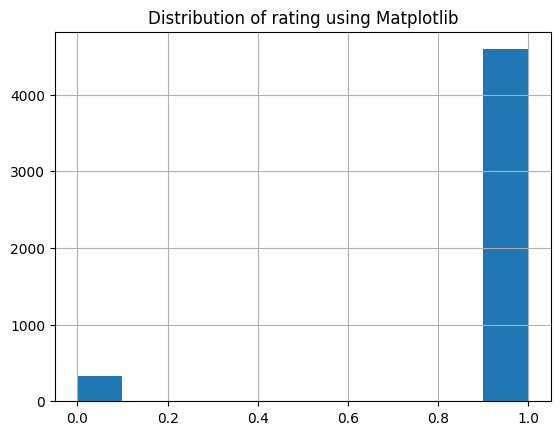

In [ ]:
df.sentiments.hist()
plt.title("Distribution of rating using Matplotlib")
plt.show()

In [ ]:
X = df['reviewText']
y = df['sentiments']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 37)

In [ ]:
X.shape

(4915,)

In [ ]:
y.shape


(4915,)

### **Tokenizing**

In [ ]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_token)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [ ]:
vocab_length=len(word_index)+1

In [ ]:
vocab_length

7786

### **Sequences**

In [ ]:
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# **Padding**

In [ ]:
X_train_padded = pad_sequences(X_train_sequences,
                               maxlen = max_length,
                               padding = padding_type)
X_test_padded = pad_sequences(X_test_sequences,
                             maxlen = max_length,
                             padding = padding_type
                             )

In [ ]:
from numpy import asarray
from numpy import zeros


## **Word Embeddings**

In [ ]:
embeddings_dictionary = dict()
glove_file = open('/content/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()
print(len(embeddings_dictionary))

15895


### Embedding training set, if a word is not in the standard embedding index it will be represented as a 0

In [ ]:
embedding_matrix = np.zeros((vocab_length, max_length))
for word, i in word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
embedding_matrix.shape

(7786, 100)

### **Creating embedding layer**

In [ ]:
embedding_layer = Embedding(input_dim = vocab_length,
                           output_dim = max_length,
                           weights = [embedding_matrix],
                           input_length = max_length,
                           trainable = False)

# **K-Fold Creation**

In [ ]:
inputs = np.concatenate((X_train_padded, X_test_padded), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

kfold = KFold(n_splits=num_folds, shuffle=True)

## Create Model, compile, train using KFold

In [ ]:
fold_num = 1
embedding_vector_features=40
acc_per_fold = []
loss_per_fold = []
for train, test in kfold.split(inputs, targets):
  model = Sequential()
  model.add(embedding_layer)
  model.add(Conv1D(128, 5, activation='relu'))
  #model.add(SpatialDropout1D(0.25))
  model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  #model compile
  model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
  #print(model.summary())
  # Generate a print
  print('----------------------------------------------------------------------------------------')
  print(f'Training for fold {fold_num} ...')
  # Fit data to model
  history=model.fit(X_train_padded,y_train,validation_data=(X_test_padded,y_test),epochs=10,batch_size=64)

  # Generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_num}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  fold_num = fold_num + 1




----------------------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
62/62 [==============================] - 29s 399ms/step - loss: 0.3637 - accuracy: 0.9270 - val_loss: 0.2292 - val_accuracy: 0.9369
Epoch 2/10
62/62 [==============================] - 18s 298ms/step - loss: 0.2424 - accuracy: 0.9323 - val_loss: 0.2294 - val_accuracy: 0.9369
Epoch 3/10
62/62 [==============================] - 23s 377ms/step - loss: 0.2398 - accuracy: 0.9331 - val_loss: 0.2252 - val_accuracy: 0.9379
Epoch 4/10
62/62 [==============================] - 25s 398ms/step - loss: 0.2371 - accuracy: 0.9326 - val_loss: 0.2279 - val_accuracy: 0.9369
Epoch 5/10
62/62 [==============================] - 18s 289ms/step - loss: 0.2273 - accuracy: 0.9359 - val_loss: 0.2219 - val_accuracy: 0.9400
Epoch 6/10
62/62 [==============================] - 24s 392ms/step - loss: 0.2225 - accuracy: 0.9385 - val_loss: 0.2267 - val_accuracy: 0.9390
Epoch 7/10
62/62 [===========

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)}')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.16078579425811768 - Accuracy: 94.37675476074219%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.13156718015670776 - Accuracy: 94.21458840370178%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.19639910757541656 - Accuracy: 93.57030391693115%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.16363435983657837 - Accuracy: 94.27594542503357%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.1875602751970291 - Accuracy: 93.87272000312805%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 94.06206250190735
> Loss: 0.1679893434047699
------------------------------------------------

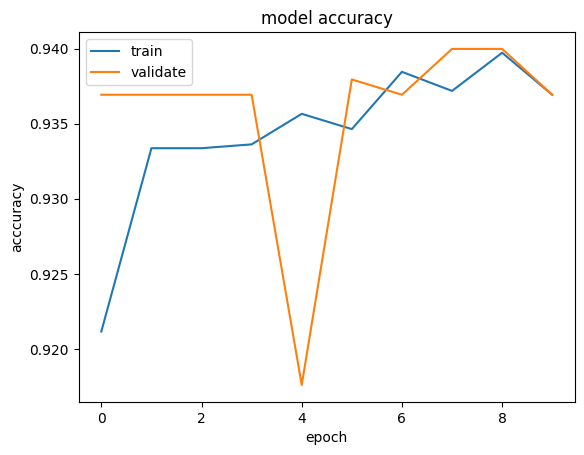

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acccuracy')
plt.xlabel('epoch')
#plt.ylim(0.8,0.94)
plt.legend(['train', 'validate'], loc = 'upper left')
plt.show()

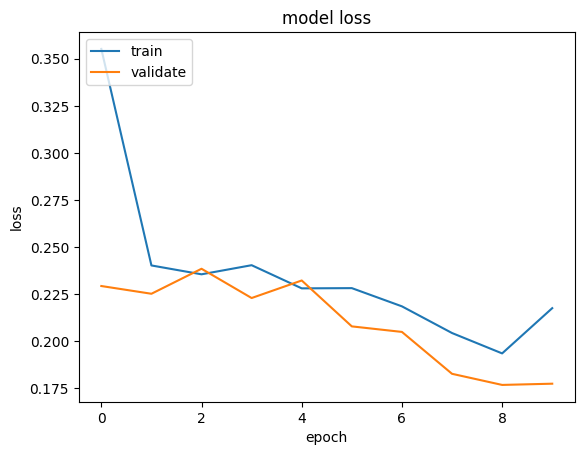

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc = 'upper left')
plt.show()


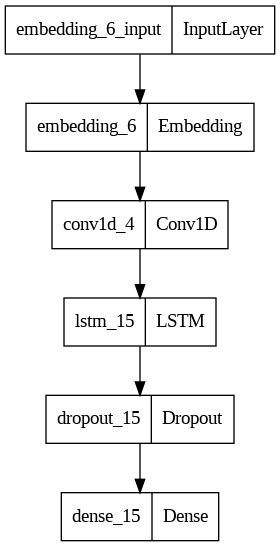

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_dtype=False,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96
)

In [ ]:
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
model.save('lstm_model.h5')